In [1]:
# %%writefile feature_format.py
# %load feature_format.py
#!/usr/bin/python

""" 
    A general tool for converting data from the
    dictionary format to an (n x k) python list that's 
    ready for training an sklearn algorithm

    n--no. of key-value pairs in dictonary
    k--no. of features being extracted

    dictionary keys are names of persons in dataset
    dictionary values are dictionaries, where each
        key-value pair in the dict is the name
        of a feature, and its value for that person

    In addition to converting a dictionary to a numpy 
    array, you may want to separate the labels from the
    features--this is what targetFeatureSplit is for

    so, if you want to have the poi label as the target,
    and the features you want to use are the person's
    salary and bonus, here's what you would do:

    feature_list = ["poi", "salary", "bonus"] 
    data_array = featureFormat( data_dictionary, feature_list )
    label, features = targetFeatureSplit(data_array)

    the line above (targetFeatureSplit) assumes that the
    label is the _first_ item in feature_list--very important
    that poi is listed first!
"""


import numpy as np

def featureFormat( dictionary, features, remove_NaN=True, remove_all_zeroes=True, remove_any_zeroes=False, sort_keys = False):
    """ convert dictionary to numpy array of features
        remove_NaN = True will convert "NaN" string to 0.0
        remove_all_zeroes = True will omit any data points for which
            all the features you seek are 0.0
        remove_any_zeroes = True will omit any data points for which
            any of the features you seek are 0.0
        sort_keys = True sorts keys by alphabetical order. Setting the value as
            a string opens the corresponding pickle file with a preset key
            order (this is used for Python 3 compatibility, and sort_keys
            should be left as False for the course mini-projects).
        NOTE: first feature is assumed to be 'poi' and is not checked for
            removal for zero or missing values.
    """


    return_list = []

    # Key order - first branch is for Python 3 compatibility on mini-projects,
    # second branch is for compatibility on final project.
    if isinstance(sort_keys, str):
        import pickle
        keys = pickle.load(open(sort_keys, "rb"))
    elif sort_keys:
        keys = sorted(dictionary.keys())
    else:
        keys = dictionary.keys()

    for key in keys:
        tmp_list = []
        for feature in features:
            try:
                dictionary[key][feature]
            except KeyError:
                print "error: key ", feature, " not present"
                return
            value = dictionary[key][feature]
            if value=="NaN" and remove_NaN:
                value = 0
            tmp_list.append( float(value) )

        # Logic for deciding whether or not to add the data point.
        append = True
        # exclude 'poi' class as criteria.
        if features[0] == 'poi':
            test_list = tmp_list[1:]
        else:
            test_list = tmp_list
        ### if all features are zero and you want to remove
        ### data points that are all zero, do that here
        if remove_all_zeroes:
            append = False
            for item in test_list:
                if item != 0 and item != "NaN":
                    append = True
                    break
        ### if any features for a given data point are zero
        ### and you want to remove data points with any zeroes,
        ### handle that here
        if remove_any_zeroes:
            if 0 in test_list or "NaN" in test_list:
                append = False
        ### Append the data point if flagged for addition.
        if append:
            return_list.append( np.array(tmp_list) )

    return np.array(return_list)


def targetFeatureSplit( data ):
    """ 
        given a numpy array like the one returned from
        featureFormat, separate out the first feature
        and put it into its own list (this should be the 
        quantity you want to predict)

        return targets and features as separate lists

        (sklearn can generally handle both lists and numpy arrays as 
        input formats when training/predicting)
    """

    target = []
    features = []
    for item in data:
        target.append( item[0] )
        features.append( item[1:] )

    return target, features

What's the slope of your regression?
[[ 5.07793064]]
[ 25.21002327]
What's the score when using your regression to make predictions with the test data?
0.878262478835


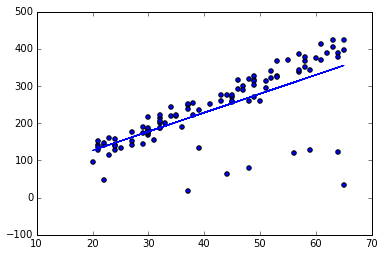

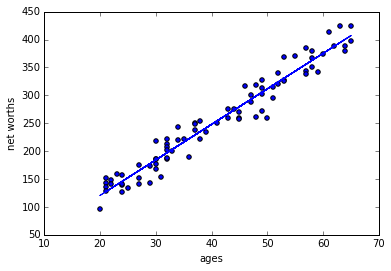

In [2]:
# %%writefile outlier_removal_regression.py
# %load outlier_removal_regression.py
#!/usr/bin/python

import random
import numpy
import matplotlib.pyplot as plt
import pickle
from sklearn import linear_model
%matplotlib inline


#from outlier_cleaner import outlierCleaner
def outlierCleaner(predictions, ages, net_worths):
    """
        clean away the 10% of points that have the largest
        residual errors (different between the prediction
        and the actual net worth)

        return a list of tuples named cleaned_data where 
        each tuple is of the form (age, net_worth, error)
    """
    
    cleaned_data = []
    
    ### your code goes here
   
    netwerr = (net_worths-predictions)**2
    databyerr = zip(ages,net_worths,netwerr)
    databyerr = sorted(databyerr,key=lambda x:x[2][0],reverse=True)
    sortlimit = int(len(databyerr)*0.1)
    
    cleaned_data = databyerr[sortlimit:]
    
    return cleaned_data



### load up some practice data with outliers in it
ages = pickle.load( open("data/practice_outliers_ages.pkl", "r") )
net_worths = pickle.load( open("data/practice_outliers_net_worths.pkl", "r") )


### ages and net_worths need to be reshaped into 2D numpy arrays
### second argument of reshape command is a tuple of integers: (n_rows, n_columns)
### by convention, n_rows is the number of data points
### and n_columns is the number of features
ages       = numpy.reshape( numpy.array(ages), (len(ages), 1))
net_worths = numpy.reshape( numpy.array(net_worths), (len(net_worths), 1))
from sklearn.cross_validation import train_test_split
ages_train, ages_test, net_worths_train, net_worths_test = train_test_split(ages, net_worths, test_size=0.1, random_state=42)

### fill in a regression here!  Name the regression object reg so that
### the plotting code below works, and you can see what your regression looks like

reg = linear_model.LinearRegression()

reg.fit(ages_train,net_worths_train)

cleaned_data = outlierCleaner(reg.predict(ages_train),ages_train,net_worths_train)
cleaned_age = numpy.array([i[0] for i in cleaned_data])
cleaned_netw = numpy.array([i[1] for i in cleaned_data])

#reg.fit(cleaned_age,cleaned_netw)
reg.fit(ages_train,net_worths_train)

predict = reg.predict(net_worths_test)

print "What's the slope of your regression?"
slope = reg.coef_
print slope

intercept = reg.intercept_
print intercept

print "What's the score when using your regression to make predictions with the test data?"
score = reg.score(ages_test,net_worths_test)
print score


try:
    plt.plot(ages, reg.predict(ages), color="blue")
except NameError:
    pass
plt.scatter(ages, net_worths)
plt.show()



### identify and remove the most outlier-y points
cleaned_data = []
try:
    predictions = reg.predict(ages_train)
    cleaned_data = outlierCleaner( predictions, ages_train, net_worths_train )
except NameError:
    print "your regression object doesn't exist, or isn't name reg"
    print "can't make predictions to use in identifying outliers"



### only run this code if cleaned_data is returning data
if len(cleaned_data) > 0:
    ages, net_worths, errors = zip(*cleaned_data)
    ages       = numpy.reshape( numpy.array(ages), (len(ages), 1))
    net_worths = numpy.reshape( numpy.array(net_worths), (len(net_worths), 1))

    ### refit your cleaned data!
    try:
        reg.fit(ages, net_worths)
        plt.plot(ages, reg.predict(ages), color="blue")
    except NameError:
        print "you don't seem to have regression imported/created,"
        print "   or else your regression object isn't named reg"
        print "   either way, only draw the scatter plot of the cleaned data"
    plt.scatter(ages, net_worths)
    plt.xlabel("ages")
    plt.ylabel("net worths")
    plt.show()


else:
    print "outlierCleaner() is returning an empty list, no refitting to be done"

Show the outliers on a scatter plot
97343619.0
What is the source of the most extreme outlier?
What are the names associated with the current Enron outliers?
[('SKILLING JEFFREY K', 1111258), ('LAY KENNETH L', 1072321)]


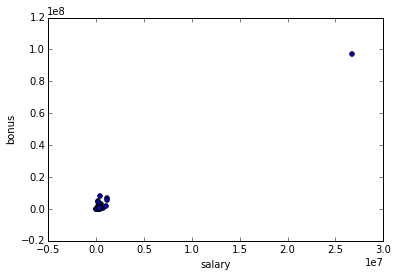

In [3]:
# %%writefile enron_outliers.py
# %load enron_outliers.py
#!/usr/bin/python

import pickle
import sys
import matplotlib.pyplot
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit


### read in data dictionary, convert to numpy array
data_dict = pickle.load( open("data/final_project_dataset.pkl", "r") )
features = ["salary", "bonus"]
data = featureFormat(data_dict, features)


### your code below
print "Show the outliers on a scatter plot"
print data.max()

for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")


print "What is the source of the most extreme outlier?"
data_dict.pop('TOTAL',0)


print "What are the names associated with the current Enron outliers?"
outliers = []
for key in data_dict:
    val = data_dict[key]['salary']
    if val == 'NaN':
        continue
    outliers.append((key,int(val)))

print sorted(outliers,key=lambda x:x[1],reverse=True)[:2]